In [1]:
import sys
sys.path.append("D:/workspace")
from repository.data_loaders import MZ_orthophoto_client, MZ_masks_client
from repository.core import TileBankRepository
import os
from tqdm import tqdm
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# INPUT_ROOT_DIR = 'E:/RD 51-61_290525/Data_MAFtoTechnoLogica/Data_PART1_tifAA2016-2024_AOI1'
INPUT_ROOT_DIR = 'E:DOPM_210825'

YEAR = 2016
ZONE = "B4"

orthophoto_client = MZ_orthophoto_client(INPUT_ROOT_DIR)
mask_client = MZ_masks_client()
repository = TileBankRepository()

Creating new database in path:  D:/tile_bank.db


In [4]:
orthophoto_client.get_orthophoto_tiles(year=2016, zone=ZONE)


[(2016, 'B4', '006')]

In [5]:
tiles = orthophoto_client.get_orthophoto_tiles(year=YEAR)
tiles.sort()
print(f"Number of tiles to process: {len(tiles)}")

Number of tiles to process: 1087


In [6]:
for year, zone, tile in tqdm(tiles, desc="Processing tiles"):
    
    features = mask_client.extract_features(year=year, task="ntp", zone=zone, tile_no=tile, verbose=False)
    meta = orthophoto_client.get_meta_of_tile(tile=tile, year=year, zone=zone)
    
    mask_path = f"ntp_{year}_{zone}_{tile}.tif"
    mask_client.save_features_to_raster(features=features, output_path=os.path.join("temp", mask_path), meta=meta)
    orthophoto_path = orthophoto_client.get_orthophoto_path_from_tile(tile=tile, year=year, zone=zone)
    
    repository.save_raster_patches_with_masks(
        raster_path=orthophoto_path,
        mask_path=os.path.join("temp", mask_path),
        satellite_name="orthophoto",
        task="ntp",
        mask_type="segmentation",
        date_origin=datetime(year, 1, 1),
        patch_size=256,
        validator=None,
        stride=256,
        file_format='npy')

Processing tiles:  86%|████████▌ | 936/1087 [22:50:42<3:41:07, 87.87s/it] 


KeyboardInterrupt: 

In [7]:
repository.save_changes()

In [8]:
df = repository.execute_query("SELECT * FROM tile JOIN mask ON tile.id = mask.tile_id JOIN satellite ON tile.satellite_id = satellite.id WHERE satellite.name = 'orthophoto' AND tile.date_origin = '2016-01-01' AND mask.task = 'ntp' AND mask.mask_type = 'segmentation'")

In [9]:
len(df)

1423656

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 256, 256) (1, 256, 256)


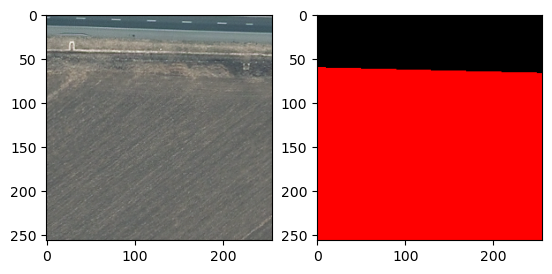

In [16]:
# test load and visualize tile

sample = df.iloc[666]

input_data = np.load(sample['path'])
mask_data = np.load(sample['path_1'])
mask_image = np.zeros((mask_data.shape[1], mask_data.shape[2], 3))
for i in range(mask_data.shape[0]):
    mask_image[mask_data[i] == 1] = (255, 0, 0)
    mask_image[mask_data[i] == 2] = (0, 255, 0)
    mask_image[mask_data[i] == 3] = (0, 0, 255)
    mask_image[mask_data[i] == 5] = (255, 255, 0)
    mask_image[mask_data[i] == 5] = (0, 0, 0)

print(input_data.shape, mask_data.shape)
plt.subplot(1, 2, 1)
plt.imshow(input_data.transpose(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask_image)
plt.show()

In [17]:
orthophoto_client.get_zones_for_year(year=2016)

['B4', 'B5']

In [ ]:
def load_tiles_for_year(year: int):
    zones = orthophoto_client.get_zones_for_year(year=year)
    for zone in zones:
        tiles = orthophoto_client.get_orthophoto_tiles(year=year, zone=zone)
    
        for tile in tqdm(tiles[0:1], desc="Processing tiles"):
            features = mask_client.extract_features(year=year, task="lulc", zone=ZONE, tile_no=tile, verbose=False)
            meta = orthophoto_client.get_meta_of_tile(tile=tile, year=year, zone=ZONE)
            
            mask_path = f"ntp_{year}_{ZONE}_{tile}.tif"
            mask_client.save_features_to_raster(features=features, output_path=os.path.join("temp", mask_path), meta=meta)
            orthophoto_path = orthophoto_client.get_orthophoto_path_from_tile(tile=tile, year=year, zone=ZONE)
            
            repository.save_raster_patches_with_masks(
                raster_path=orthophoto_path,
                mask_path=os.path.join("temp", mask_path),
                satellite_name="orthophoto",
                task="ntp",
                mask_type="segmentation",
                date_origin=datetime(YEAR, 1, 1),
                patch_size=256,
                validator=None,
                stride=256,
                file_format='npy')

In [5]:
features = mask_client.extract_features(year=YEAR, task="ntp", zone=ZONE, tile_no=tiles[0], verbose=False)